In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM
from tqdm import tqdm


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.family'] = 'Calibri'

path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1,2]

num_trained_seq = 1

total_sub_num = 20
num_sessions = 3
num_blocks_per_session = 4

num_baseline_blocks = 1
num_trials_per_block = 40

percentile_low = 45;	# Lower percentile for ETs
percentile_high = 80;	# Upper percentile for ETs
percentile_low_super = 10;	# Lower percentile for ETs


In [16]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

def set_figure_style(scale="1col"):
    """
    Set figure styling based on publication constraints.
    
    Parameters:
        scale (str): Scale of the figure, choose from "1col", "1.5col", "2col".
                     - "1col" for 8.5cm
                     - "1.5col" for 11.6cm
                     - "2col" for 17.6cm
    """
    # Define width options in cm
    widths = {"1col": 7.62, "1.5col": 11.6, "2col": 16.5}
    
    if scale not in widths:
        raise ValueError("Invalid scale. Choose from '1col', '1.5col', or '2col'.")
    
    # Convert width from cm to inches (1 cm = 0.393701 inches)
    width_in = widths[scale] * 0.393701
    
    # Set figure size (width, height)
    # Assuming height proportional to width (Golden Ratio)
    golden_ratio = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden_ratio)
    
    # Set font sizes
    rcParams["font.size"] = 10  # General font size
    # rcParams["font.size"] = 20  # General font size
    rcParams["axes.titlesize"] = 12  # Figure title
    # rcParams["axes.titlesize"] = 26  # Figure title
    rcParams["axes.labelsize"] = 9  # Axis main label
    # rcParams["axes.labelsize"] = 22  # Axis main label
    rcParams["xtick.labelsize"] = 7  # Tick labels
    # rcParams["xtick.labelsize"] = 16  # Tick labels
    rcParams["ytick.labelsize"] = 7
    # rcParams["ytick.labelsize"] = 16
    rcParams["legend.fontsize"] = 8  # Legend entries
    # rcParams["legend.fontsize"] = 20  # Legend entries
    rcParams["figure.titleweight"] = "bold"
    
    # Set stroke width
    rcParams["axes.linewidth"] = 0.75
    # rcParams["axes.linewidth"] = 1.5

    # rcParams["lines.linewidth"] = 3
    
    rcParams["xtick.major.width"] = 0.75
    # rcParams["xtick.major.width"] = 1.5
    rcParams["ytick.major.width"] = 0.75
    # rcParams["ytick.major.width"] = 1.5

    
    # Subpanel lettering size
    rcParams["text.usetex"] = False  # Set to True if using LaTeX
    rcParams["axes.formatter.use_mathtext"] = True  # Math text for scientific notation

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """
    Add a subpanel label (e.g., 'a', 'b') to a subplot.
    
    Parameters:
        ax (Axes): Matplotlib Axes object.
        label (str): The label text.
        fontsize (int): Font size for the label.
        position (tuple): Position of the label in axes coordinates.
    """
    ax.text(position[0], position[1], label, transform=ax.transAxes, 
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

###
set_figure_style(scale="1col")




In [17]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [18]:
sns.set_palette("colorblind")

In [19]:
# reload utils
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/amin/projects/LearningDynamics/SequenceLearningReward/utils.py'>

In [20]:
subjs_list = utils.read_dat_files_subjs_list(sub_nums)

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)


subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

# Mov Files

In [22]:
import glob
import os
def movload(fname):
    # loads .mov files given the path of the file. The .mov files have a specific custom hence the need for a custom function
    A = []
    fid = open(fname, 'rt')
    if fid == -1:
        raise Exception('Could not open ' + fname)


    num_columns = None 

    trial = 0
    for line in fid:
        if line[0] == 'T':
            # print('Trial: ', line.split()[1])
            a = int(line.split()[1])
            trial += 1
            if a != trial:
                print('Trials out of sequence')
                trial = a
            A.append([])
            num_columns = None
            # A[trial-1] = np.empty((0,8))
        else:
            lineData = line.strip().split('\t')
            if num_columns is None:
                num_columns = len(lineData)
                A[trial - 1] = np.empty((0, num_columns))
            a = np.array([float(x) for x in lineData], ndmin=2)
            # print(a)
            A[trial-1] = np.vstack((A[trial-1],a))
            # A[trial-1].extend(a)

    fid.close()
    return A
pattern = utils.path +  "_*_*.mov"
files = glob.glob(pattern)
dfs = []
for file in files:
    filename = os.path.basename(file)

    parts = filename.split('_')

    if len(parts) >= 3:
        subnum = int(parts[1])
        block_number = int(parts[2].replace('.mov', ''))

        print(subnum, block_number)

        trials = movload(file)
        for trial_idx, trial in enumerate(trials):
            df = pd.DataFrame(trial, columns=['state',
                                              'timeReal', 'time',
                                              'force1R', 'force2R', 'force3R', 'force4R', 'force5R'])
            df['TN'] = trial_idx + 1
            df['BN'] = block_number
            df['SubNum'] = subnum
            dfs.append(df)
        

dfs = pd.concat(dfs)


subjs_force = dfs.merge(subjs, on = ['SubNum' , 'BN', 'TN'], how='inner')

1 9
1 8
2 4
2 10
2 11
2 5
2 13
2 7
2 6
2 12
2 2
2 3
2 1
2 8
2 9
1 3
1 2
1 1
1 5
1 11
1 10
1 4
1 12
1 6
1 7
1 13


Lower bound: 4.929000000003725, Upper bound: 5.070000000065193


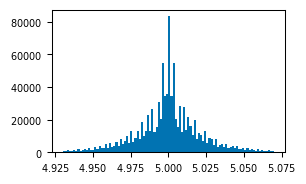

****************
SubNum: (1,), BN: (1,), TN: (1,)
   state    timeReal  time  force1R  force2R  force3R  force4R  force5R  TN  \
2    4.0  212931.408  10.0     0.07   -0.001     -0.0     0.17    0.042   1   

   BN  SubNum  
2   1       1  
2    11.334
Name: timeReal, dtype: float64
****************
SubNum: (1,), BN: (6,), TN: (1,)
   state   timeReal  time  force1R  force2R  force3R  force4R  force5R  TN  \
2    4.0  134785.38  10.0    0.046     -0.0    0.006    0.029   -0.004   1   

   BN  SubNum  
2   6       1  
2    10.308
Name: timeReal, dtype: float64
****************
SubNum: (1,), BN: (10,), TN: (1,)
   state  timeReal  time  force1R  force2R  force3R  force4R  force5R  TN  BN  \
2    4.0  275768.1  10.0      0.0    0.004    0.002   -0.008      0.0   1  10   

   SubNum  
2       1  
2    13.028
Name: timeReal, dtype: float64
****************
SubNum: (2,), BN: (1,), TN: (1,)
   state  timeReal  time  force1R  force2R  force3R  force4R  force5R  TN  BN  \
2    4.0   74047.7  10

In [23]:
## --- plotting time real increments in the data ----

diffs = []
# df_filtered = dfs[(dfs['SubNum'] == 1) & (dfs['BN'] == 10) & (dfs['TN'] == 1)]
for sub, subdata in dfs.groupby(['SubNum']):
    for block, blockdata in subdata.groupby(['BN']):
        for trial, trialdata in blockdata.groupby(['TN']):
            # diffs = np.append(diffs, trialdata['timeReal'].diff())
            diffs.extend(trialdata['timeReal'].diff().dropna())

diffs = np.array(diffs)
# diffs = diffs[(diffs > 0) & (diffs < 100)]
# print(diffs.shape)
# print(diffs)
# print(sorted(diffs)[:10])
# print(sorted(diffs)[-10:])

# 95 and 5 percentile
lower_bound = np.percentile(diffs, 1)
upper_bound = np.percentile(diffs, 99)
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

diffs = diffs[(diffs > lower_bound) & (diffs < upper_bound)]


plt.hist(diffs, bins=100)
# print(sorted(diffs)[-100:])
# print(sorted(diffs)[:100])
plt.show()

# df_filtered = dfs[(dfs['SubNum'] == 1) & (dfs['BN'] == 10) & (dfs['TN'] == 1)]
for sub, subdata in dfs.groupby(['SubNum']):
    for block, blockdata in subdata.groupby(['BN']):
        for trial, trialdata in blockdata.groupby(['TN']):
            # diffs = np.append(diffs, trialdata['timeReal'].diff())
            diffs = trialdata['timeReal'].diff()
            # return index of diffs greater than 10 if any
            if diffs[diffs > 10].any():
                print("****************")
                print(f"SubNum: {sub}, BN: {block}, TN: {trial}")
                print(trialdata[diffs > 10])
                print(diffs[diffs > 10])

In [24]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/amin/projects/LearningDynamics/SequenceLearningReward/utils.py'>

In [25]:
# exclude first block 
subjs_force_train = subjs_force[subjs_force['BN'] > 1]

In [26]:
subjs_force_train = utils.finger_melt_Forces(subjs_force_train)

In [27]:
rank_df = pd.DataFrame(index = subjs_force_train.index)
for subnum, data in subjs_force_train.groupby('SubNum'):
    data = data.sort_values(by = ['BN', 'TN'])
    data['N'] = data.groupby(['BN', 'TN']).ngroup() + 1
    rank_df.loc[data.index, 'N'] = data['N'].astype('int')
        

subjs_force_train['N'] = rank_df['N'].astype('int')

In [28]:
subjs_force_train.to_csv(utils.path_misc+'subjs_force_train.csv', index = False, sep = '\t')
# subjs_force_train = pd.read_csv(utils.path_misc+'subjs_force_train.csv', sep = '\t')

Forces at RT: [500]
        Force_Number  Force_Value
358351       force1R        0.109
1245587      force2R        0.016
2132823      force3R        1.320
3020059      force4R        0.078
3907295      force5R        0.006
Forces at ET: [1825]
        Force_Number  Force_Value
358616       force1R        0.005
1245852      force2R        0.111
2133088      force3R        0.002
3020324      force4R        0.822
3907560      force5R        0.003
state change times:  [   0.    5. 2030. 2035. 3040.]


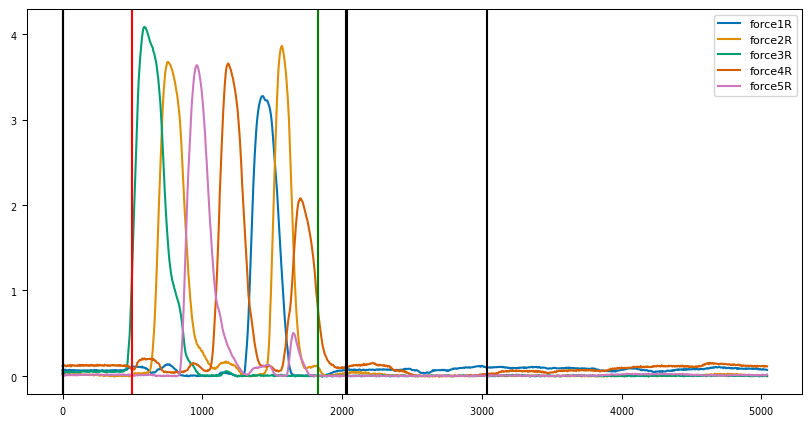

In [29]:
plt.figure(figsize=(10, 5))
x = subjs_force_train[(subjs_force_train['SubNum'] == 2) & (subjs_force_train['N'] == 4)]
# state_changes = x[x['state'].diff() != 0].index

for force, data in x.groupby('Force_Number'):
    plt.plot(data['time'], data['Force_Value'], label = force)





# for i in range(1,6):
#     plt.plot(x['time'], x[f'force{i}'], label = i)

state_changes = x[x['state'].diff() != 0].index

state_changes = x.loc[state_changes]['time'].unique()

for change in state_changes:
    plt.axvline(change, color = 'black')


plt.axvline(x['RT'].unique(), color = 'red')
plt.axvline(x['ET'].unique(), color = 'green')

# forces at RT
print("Forces at RT:", x['RT'].unique())
print(x[x['time'] == x['RT']][['Force_Number', 'Force_Value']])

# forces at ET
print("Forces at ET:", x['ET'].unique())
print(x[x['time'] == x['ET']][['Force_Number', 'Force_Value']])


print("state change times: ",state_changes)


# print(x['seq'].unique())


plt.legend()

plt.show()

In [30]:
subjs_force_train_cp = subjs_force_train.copy()
for sub, subdata in subjs_force_train.groupby('SubNum'):
    for bn, bndata in subdata.groupby('BN'):
        for tn, tndata in bndata.groupby('TN'):
            for force, data in tndata.groupby('Force_Number'):
                #extract the first 50 ms
                baseline = data[data['time'] < 50]['Force_Value'].mean()
                subjs_force_train_cp.loc[data.index, 'Force_Value'] = data['Force_Value'] - baseline


subjs_force_train = subjs_force_train_cp

Forces at RT: [500]
        Force_Number  Force_Value
358351       force1R       0.0419
1245587      force2R      -0.0020
2132823      force3R       1.2776
3020059      force4R      -0.0413
3907295      force5R      -0.0039
Forces at ET: [1825]
        Force_Number  Force_Value
358616       force1R      -0.0621
1245852      force2R       0.0930
2133088      force3R      -0.0404
3020324      force4R       0.7027
3907560      force5R      -0.0069
state change times:  [   0.    5. 2030. 2035. 3040.]


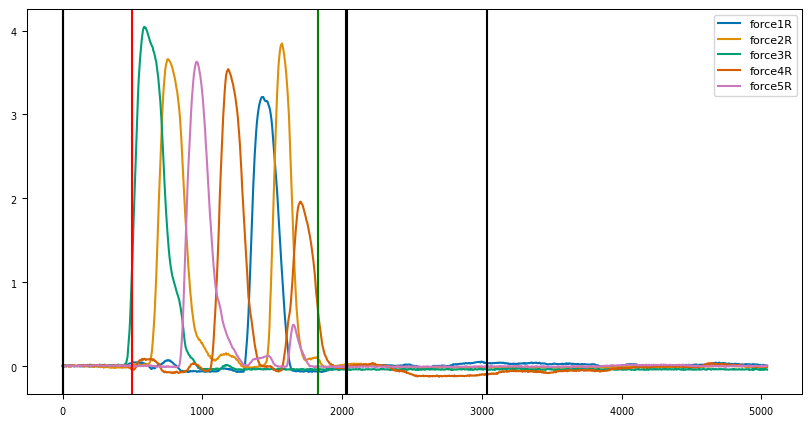

In [31]:
plt.figure(figsize=(10, 5))
x = subjs_force_train[(subjs_force_train['SubNum'] == 2) & (subjs_force_train['N'] == 4)]
# state_changes = x[x['state'].diff() != 0].index

for force, data in x.groupby('Force_Number'):
    plt.plot(data['time'], data['Force_Value'], label = force)





# for i in range(1,6):
#     plt.plot(x['time'], x[f'force{i}'], label = i)

state_changes = x[x['state'].diff() != 0].index

state_changes = x.loc[state_changes]['time'].unique()

for change in state_changes:
    plt.axvline(change, color = 'black')


plt.axvline(x['RT'].unique(), color = 'red')
plt.axvline(x['ET'].unique(), color = 'green')

# forces at RT
print("Forces at RT:", x['RT'].unique())
print(x[x['time'] == x['RT']][['Force_Number', 'Force_Value']])

# forces at ET
print("Forces at ET:", x['ET'].unique())
print(x[x['time'] == x['ET']][['Force_Number', 'Force_Value']])


print("state change times: ",state_changes)


# print(x['seq'].unique())


plt.legend()

plt.show()

In [32]:
def plot_force(subjs_force, subnum, bn, tn):
    plt.figure(figsize=(10, 5))
    x = subjs_force[(subjs_force['SubNum'] == subnum) & (subjs_force['BN'] == bn) & (subjs_force['TN'] == tn)]
    for force, data in x.groupby('Force_Number'):
        plt.plot(data['time'], data['Force_Value'], label = force)
    state_changes = x[x['state'].diff() != 0].index
    state_changes = x.loc[state_changes]['time'].unique()
    for change in state_changes:
        plt.axvline(change, color = 'black')

    plt.ylim([-0.2, 2])

    plt.legend()
    plt.show()
    

In [33]:
subjs_force_train_cut = utils.cut_force(subjs_force_train, 0)
subjs_force_train_cut_left = utils.cut_force_left(subjs_force_train)
subjs_force_train_cut_right = utils.cut_force_right(subjs_force_train)

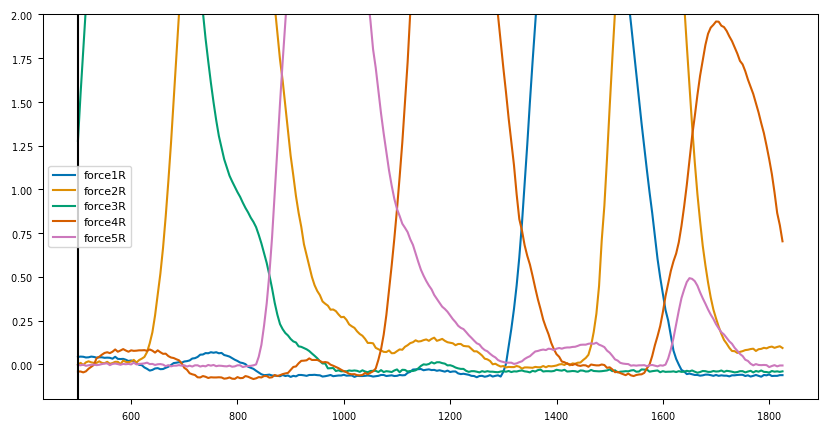

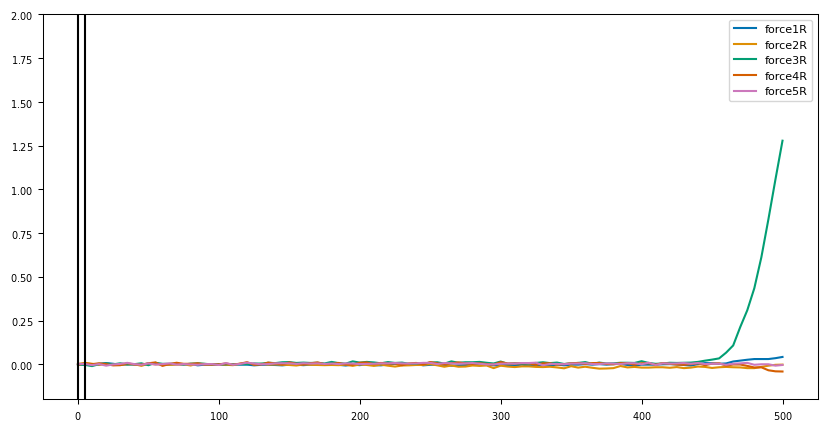

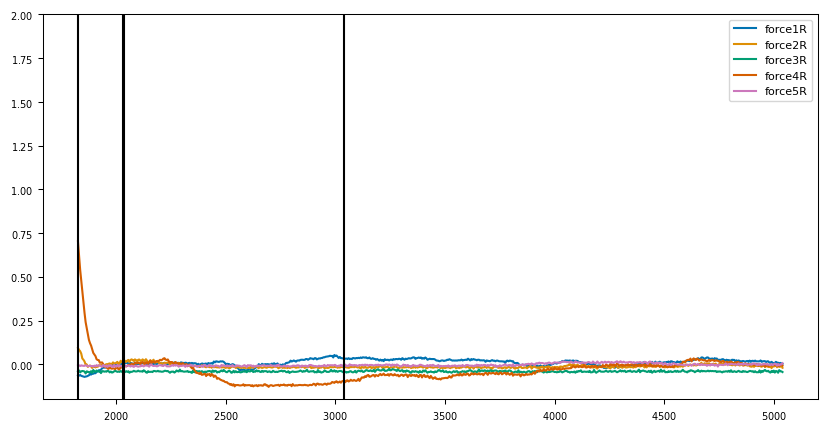

In [34]:
plot_force(subjs_force_train_cut, 2, 2, 4)
plot_force(subjs_force_train_cut_left, 2, 2, 4)
plot_force(subjs_force_train_cut_right, 2, 2, 4)

In [35]:
n_samples = 300
n_samples_left_right = 30
aligned_cut_force = pd.DataFrame(columns=subjs_force_train.columns)
interpolated_data = []
x_center_interp = np.linspace(0, 1, n_samples)
interval = x_center_interp[1] - x_center_interp[0]
x_right_interp = np.linspace(x_center_interp[-1] + interval, x_center_interp[-1] + interval * n_samples_left_right, n_samples_left_right) - 1
x_left_interp = np.linspace(x_center_interp[0] - interval * n_samples_left_right, x_center_interp[0] - interval, n_samples_left_right) + 1


for sub, subdata in tqdm(subjs_force_train_cut_left.groupby('SubNum')):
    for bn, bndata in subdata.groupby('BN'):
        for tn, tndata in bndata.groupby('TN'):
            for force, data in tndata.groupby('Force_Number'):
                warped_force = np.interp(x_left_interp, np.linspace(0,1, len(data)), data['Force_Value'])

                
                interpolated_df = pd.DataFrame({
                    'state': data['state'].iloc[0],
                    'time': x_left_interp - 1,
                    'BN': bn,
                    'TN': tn,
                    'SubNum': sub,
                    'isTrain': data['isTrain'].iloc[0],
                    'isCross': data['isCross'].iloc[0],
                    'crossTime': data['crossTime'].iloc[0],
                    'points': data['points'].iloc[0],
                    'zone': data['zone'].iloc[0],
                    'isError': data['isError'].iloc[0],
                    'RT': data['RT'].iloc[0],
                    'ET': data['ET'].iloc[0],
                    'Force_Number': force,
                    'Force_Value': warped_force,
                    'N': data['N'].iloc[0]
                })
                # new_df = pd.concat([new_df, interpolated_df])
                interpolated_data.append(interpolated_df)


for sub, subdata in tqdm(subjs_force_train_cut.groupby('SubNum')):
    for bn, bndata in subdata.groupby('BN'):
        for tn, tndata in bndata.groupby('TN'):
            for force, data in tndata.groupby('Force_Number'):
                warped_force = np.interp(x_center_interp, np.linspace(0,1, len(data)), data['Force_Value'])

                
                interpolated_df = pd.DataFrame({
                    'state': data['state'].iloc[0],
                    'time': x_center_interp,
                    'BN': bn,
                    'TN': tn,
                    'SubNum': sub,
                    'isTrain': data['isTrain'].iloc[0],
                    'isCross': data['isCross'].iloc[0],
                    'crossTime': data['crossTime'].iloc[0],
                    'points': data['points'].iloc[0],
                    'zone': data['zone'].iloc[0],
                    'isError': data['isError'].iloc[0],
                    'RT': data['RT'].iloc[0],
                    'ET': data['ET'].iloc[0],
                    'Force_Number': force,
                    'Force_Value': warped_force,
                    'N': data['N'].iloc[0]
                })
                # new_df = pd.concat([new_df, interpolated_df])
                interpolated_data.append(interpolated_df)


for sub, subdata in tqdm(subjs_force_train_cut_right.groupby('SubNum')):
    for bn, bndata in subdata.groupby('BN'):
        for tn, tndata in bndata.groupby('TN'):
            for force, data in tndata.groupby('Force_Number'):
                warped_force = np.interp(x_right_interp, np.linspace(0,1, len(data)), data['Force_Value'])
                
                interpolated_df = pd.DataFrame({
                    'state': data['state'].iloc[0],
                    'time': x_right_interp + 1,
                    'BN': bn,
                    'TN': tn,
                    'SubNum': sub,
                    'isTrain': data['isTrain'].iloc[0],
                    'isCross': data['isCross'].iloc[0],
                    'crossTime': data['crossTime'].iloc[0],
                    'points': data['points'].iloc[0],
                    'zone': data['zone'].iloc[0],
                    'isError': data['isError'].iloc[0],
                    'RT': data['RT'].iloc[0],
                    'ET': data['ET'].iloc[0],
                    'Force_Number': force,
                    'Force_Value': warped_force,
                    'N': data['N'].iloc[0]
                })
                # new_df = pd.concat([new_df, interpolated_df])
                interpolated_data.append(interpolated_df)




aligned_cut_force = pd.concat(interpolated_data, ignore_index=True)


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


In [36]:
aligned_cut_force.to_csv(utils.path_misc+'aligned_cut_force.csv', index = False, sep = '\t')
# aligned_cut_force = pd.read_csv(utils.path_misc+'aligned_cut_force.csv', sep = '\t')


[-0.10033445  0.        ]


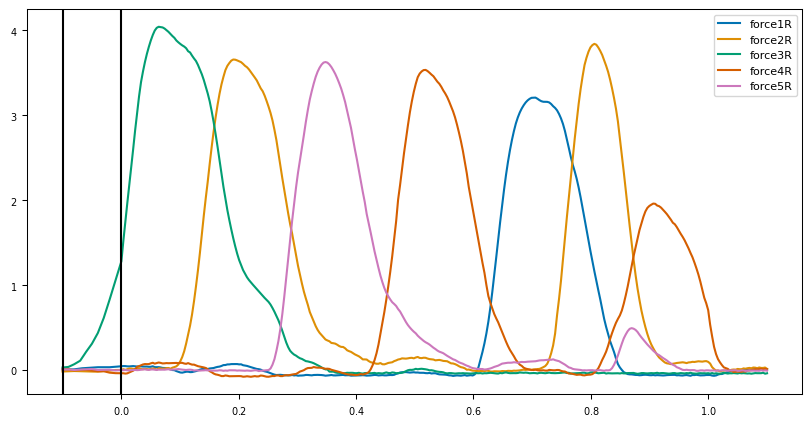

In [37]:
plt.figure(figsize=(10, 5))
x = aligned_cut_force[(aligned_cut_force['SubNum'] == 2) & (aligned_cut_force['N'] == 4)]

# x = x[(x['IPI0'] <= x['time'] + side_padding) & (x['time'] <= x['IPI0'] + x['MT'] + side_padding)]

# state_changes = x[x['state'].diff() != 0].index

for force, data in x.groupby('Force_Number'):
    plt.plot(data['time'], data['Force_Value'], label = force)





# for i in range(1,6):
#     plt.plot(x['time'], x[f'force{i}'], label = i)

state_changes = x[x['state'].diff() != 0].index

state_changes = x.loc[state_changes]['time'].unique()

for change in state_changes:
    plt.axvline(change, color = 'black')

print(state_changes)

# print(x['MT'].unique(), x['IPI0'].unique())

# plt.axvline(x['IPI0'].unique(), color = 'red')

# print(x['seq'].unique())


plt.legend()

plt.show()

# PCA Processing

In [7]:
aligned_cut_force = pd.read_csv(utils.path_misc+'aligned_cut_force.csv', sep = '\t')
subjs = pd.read_csv(utils.path_misc+'subjs.csv', sep = '\t')


In [38]:
# exclude first block 
subjs = subjs[subjs['BN'] > 1]
rank_df = pd.DataFrame(index = subjs.index)
for subnum, data in subjs.groupby('SubNum'):
    data = data.sort_values(by = ['BN', 'TN'])
    data['N'] = data.groupby(['BN', 'TN']).ngroup() + 1
    rank_df.loc[data.index, 'N'] = data['N'].astype('int')
        

subjs['N'] = rank_df['N'].astype('int')

In [39]:
# drop crossed trials
aligned_cut_force = aligned_cut_force[aligned_cut_force['isCross'] == 0]
subjs = subjs[subjs['isCross'] == 0]

In [40]:
# perform PCA on the aligned cut force data
from sklearn.decomposition import PCA

n_dims = 16

processed_forces = pd.DataFrame(columns= ['SubNum', 'BN', 'TN', 'points', 'zone', 'isError', 'RT', 'ET', 'N'] + [f'PC_{i+1}' for i in range(n_dims)])

for subind, subdata in tqdm(aligned_cut_force.groupby('SubNum')):
    pca = PCA()
    trial_forces = subdata.pivot_table(index = ['N'], columns= ['Force_Number', 'time'], values = 'Force_Value')
    trial_forces_idx = trial_forces.index

    pca.fit(trial_forces.values)
    explained_variance = pca.explained_variance_ratio_
    # dim = np.argmax(np.cumsum(explained_variance) >= 0.9)  # Number of dimensions to keep for 95% variance
    # print(dim)
    dim_reduced_forces = pca.transform(trial_forces.values)[:, :n_dims]


    dim_reduced_forces_df = pd.DataFrame(dim_reduced_forces, columns=[f'PC_{i+1}' for i in range(n_dims)])

    # add N back
    dim_reduced_forces_df['N'] = trial_forces_idx.values

    # merge with the subjs based on N
    dim_reduced_forces_df = dim_reduced_forces_df.merge(subjs[subjs['SubNum'] == subind][['BN', 'TN', 'SubNum', 'points', 'zone', 'isError', 'RT', 'ET', 'N']], how = 'left', on = 'N',
                                                       validate='one_to_one')    
    # append to the processed_forces dataframe
    processed_forces = pd.concat([processed_forces, dim_reduced_forces_df], ignore_index=True)
    





    




    


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_53799/1155697415.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_forces = pd.concat([processed_forces, dim_reduced_forces_df], ignore_index=True)
100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


In [41]:
processed_forces

,SubNum,BN,TN,points,zone,isError,RT,ET,N,PC_1,...,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16
0,1,2,1,3,2,0,865,3025,1,-35.791259,...,-8.859145,-1.124657,-1.862375,-2.806480,4.042803,-2.702658,1.329692,7.132493,3.915426,0.770352
1,1,2,2,3,2,0,630,2760,2,-35.346597,...,-10.525310,-2.892923,-0.598519,-1.905218,4.839232,-1.494168,1.559656,2.754311,1.493077,1.792675
2,1,2,3,3,1,0,640,2610,3,-36.384857,...,-8.668257,-2.189336,-1.484787,-1.543115,5.377221,-1.283526,3.079953,8.905377,2.959750,-0.725868
3,1,2,4,3,1,0,520,2475,4,-37.898247,...,-3.270520,1.217196,-4.613361,0.239010,4.683112,1.629281,-0.683043,4.042244,3.084131,-0.298911
4,1,2,5,1,2,0,520,2795,5,-38.104094,...,-8.743105,-6.447783,-3.550061,5.793993,5.928707,2.668321,-4.030179,7.929705,1.136499,-2.173489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,2,13,36,0,4,0,380,1225,476,-61.919407,...,6.059544,-14.003655,-4.458097,1.858159,8.422685,-1.853511,-2.988739,6.091848,2.344899,-5.849338
953,2,13,37,0,4,0,455,1225,477,-42.108556,...,13.883573,-0.674758,-6.445657,8.287952,1.020029,-0.557182,-0.622831,1.076331,-3.118203,-0.705559
954,2,13,38,3,2,0,310,995,478,0.925167,...,14.766350,-3.378641,2.022639,-2.298341,2.302604,2.543066,-1.995528,3.326779,0.979844,-3.354398
955,2,13,39,0,3,0,330,1110,479,-16.893422,...,9.105161,0.902209,-1.560586,7.078838,-3.184350,1.509177,0.280693,0.757032,0.899017,-1.711803


In [42]:
# what row is nan in processed_forces?
nan_rows = processed_forces[processed_forces.isna().any(axis=1)]
if not nan_rows.empty:
    print("Rows with NaN values:")
    print(nan_rows)

In [43]:
# add a force vector column to the processed_forces dataframe which is a vector of all the PC values
processed_forces['force_vector'] = processed_forces[[f'PC_{i+1}' for i in range(n_dims)]].apply(lambda x: np.array(x), axis=1)



In [54]:
# adding day column to the processed_forces dataframe
day1_blocks =list(range(2, num_blocks_per_session + 2))  # Blocks 2 to 5
day2_blocks = list(range(num_blocks_per_session + 2, num_blocks_per_session * 2 + 2))  # Blocks 6 to 9
day3_blocks = list(range(num_blocks_per_session * 2 + 2, num_blocks_per_session * 3 + 2))  # Blocks 10 to 13

processed_forces['day'] = 0
processed_forces.loc[processed_forces['BN'].isin(day1_blocks), 'day'] = 1
processed_forces.loc[processed_forces['BN'].isin(day2_blocks), 'day'] = 2
processed_forces.loc[processed_forces['BN'].isin(day3_blocks), 'day'] = 3

In [55]:
# adding day change column to the processed_forces dataframe
processed_forces['day_change'] = 0
processed_forces.loc[processed_forces['day'] != processed_forces['day'].shift(1), 'day_change'] = 1


In [57]:
# adding block change column to the processed_forces dataframe
processed_forces['block_change'] = 0
processed_forces.loc[processed_forces['BN'] != processed_forces['BN'].shift(1), 'block_change'] = 1


In [58]:
processed_forces

,SubNum,BN,TN,points,zone,isError,RT,ET,N,PC_1,...,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,force_vector,day,day_change,block_change
0,1,2,1,3,2,0,865,3025,1,-35.791259,...,4.042803,-2.702658,1.329692,7.132493,3.915426,0.770352,"[-35.79125928926641, 15.622583620240068, 18.84...",1,1,1
1,1,2,2,3,2,0,630,2760,2,-35.346597,...,4.839232,-1.494168,1.559656,2.754311,1.493077,1.792675,"[-35.34659686672197, 14.368063257787002, 16.10...",1,0,0
2,1,2,3,3,1,0,640,2610,3,-36.384857,...,5.377221,-1.283526,3.079953,8.905377,2.959750,-0.725868,"[-36.384857031284234, 16.364251947146734, 18.7...",1,0,0
3,1,2,4,3,1,0,520,2475,4,-37.898247,...,4.683112,1.629281,-0.683043,4.042244,3.084131,-0.298911,"[-37.89824681275655, 15.534603315436572, 14.55...",1,0,0
4,1,2,5,1,2,0,520,2795,5,-38.104094,...,5.928707,2.668321,-4.030179,7.929705,1.136499,-2.173489,"[-38.10409362960227, 13.430860558357793, 12.98...",1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,2,13,36,0,4,0,380,1225,476,-61.919407,...,8.422685,-1.853511,-2.988739,6.091848,2.344899,-5.849338,"[-61.91940710694579, -13.354358572563521, 1.81...",3,0,0
953,2,13,37,0,4,0,455,1225,477,-42.108556,...,1.020029,-0.557182,-0.622831,1.076331,-3.118203,-0.705559,"[-42.108555686269355, -17.405704699818294, 11....",3,0,0
954,2,13,38,3,2,0,310,995,478,0.925167,...,2.302604,2.543066,-1.995528,3.326779,0.979844,-3.354398,"[0.9251674784063041, -10.55353946713212, 17.63...",3,0,0
955,2,13,39,0,3,0,330,1110,479,-16.893422,...,-3.184350,1.509177,0.280693,0.757032,0.899017,-1.711803,"[-16.893421655393663, -18.27570925262762, 12.7...",3,0,0


In [59]:
processed_forces.to_csv(utils.path_misc+'processed_forces.csv', index = False, sep = '\t')